<a href="https://colab.research.google.com/github/EMKA-ctrl/2019-Equip3/blob/master/Sesi%C3%B3n3_prueba2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**EXTRACCIÓN DE DESCRIPTORES**

Cargamos librerías

In [0]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import zipfile
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from os.path import isfile, join
from os import scandir, getcwd                        
from os import listdir
import sklearn.preprocessing as skl

plt.ion()   #interactive mode

Descomprimimos el zip de manera manual porque desde el link de GitHub no va 


In [0]:
!unzip -qq TRAINYTEST2.zip -d TRAINYTEST2/

Contamos cuantas fotos tenemos en una de las carpetas

In [0]:
dir1='TRAINYTEST2/TRAINYTEST2/TRAIN/2/catedrl'
def  count_files(dir1): 
  return len([1 for x in list (os.scandir(dir1)) if x.is_file()])

print(count_files(dir1))

58


In [0]:
# Data augmentation and normalization for TRAINing
# Just normalization for TESTidation
data_transforms = {
    'TRAIN': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'TEST': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'TRAINYTEST2/TRAINYTEST2'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['TRAIN', 'TEST']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['TRAIN', 'TEST']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['TRAIN', 'TEST']}
class_names = image_datasets['TRAIN'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Definimos la función de imshow para mirar algunas imágenes 

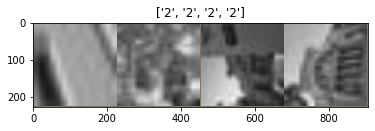

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['TRAIN']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['TRAIN', 'TEST']:
            if phase == 'TRAIN':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'TRAIN'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'TRAIN':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'TRAIN':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'TEST' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['TEST']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [0]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 77.3MB/s]


In [0]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
TRAIN Loss: 0.0299 Acc: 0.9956
TEST Loss: 0.0000 Acc: 1.0000

Epoch 1/24
----------
TRAIN Loss: 0.0000 Acc: 1.0000
TEST Loss: 0.0000 Acc: 1.0000

Epoch 2/24
----------
TRAIN Loss: 0.0000 Acc: 1.0000
TEST Loss: 0.0000 Acc: 1.0000

Epoch 3/24
----------
TRAIN Loss: 0.0000 Acc: 1.0000
TEST Loss: 0.0000 Acc: 1.0000

Epoch 4/24
----------
TRAIN Loss: 0.0000 Acc: 1.0000
TEST Loss: 0.0000 Acc: 1.0000

Epoch 5/24
----------
TRAIN Loss: 0.0000 Acc: 1.0000
TEST Loss: 0.0000 Acc: 1.0000

Epoch 6/24
----------
TRAIN Loss: 0.0000 Acc: 1.0000
TEST Loss: 0.0000 Acc: 1.0000

Epoch 7/24
----------
TRAIN Loss: 0.0000 Acc: 1.0000
TEST Loss: 0.0000 Acc: 1.0000

Epoch 8/24
----------
TRAIN Loss: 0.0000 Acc: 1.0000
TEST Loss: 0.0000 Acc: 1.0000

Epoch 9/24
----------
TRAIN Loss: 0.0000 Acc: 1.0000
TEST Loss: 0.0000 Acc: 1.0000

Epoch 10/24
----------
TRAIN Loss: 0.0000 Acc: 1.0000
TEST Loss: 0.0000 Acc: 1.0000

Epoch 11/24
----------
TRAIN Loss: 0.0000 Acc: 1.0000
TEST Loss: 0.0000 Acc

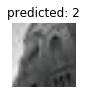

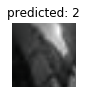

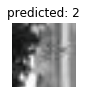

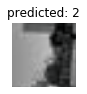

In [0]:
visualize_model(model_ft)

In [0]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [0]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
TRAIN Loss: 0.0319 Acc: 0.9912
TEST Loss: 0.0000 Acc: 1.0000

Epoch 1/24
----------
TRAIN Loss: 0.0000 Acc: 1.0000
TEST Loss: 0.0000 Acc: 1.0000

Epoch 2/24
----------
TRAIN Loss: 0.0000 Acc: 1.0000
TEST Loss: 0.0000 Acc: 1.0000

Epoch 3/24
----------
TRAIN Loss: 0.0000 Acc: 1.0000
TEST Loss: 0.0000 Acc: 1.0000

Epoch 4/24
----------
TRAIN Loss: 0.0000 Acc: 1.0000
TEST Loss: 0.0000 Acc: 1.0000

Epoch 5/24
----------
TRAIN Loss: 0.0000 Acc: 1.0000
TEST Loss: 0.0000 Acc: 1.0000

Epoch 6/24
----------
TRAIN Loss: 0.0000 Acc: 1.0000
TEST Loss: 0.0000 Acc: 1.0000

Epoch 7/24
----------
TRAIN Loss: 0.0000 Acc: 1.0000
TEST Loss: 0.0000 Acc: 1.0000

Epoch 8/24
----------
TRAIN Loss: 0.0000 Acc: 1.0000
TEST Loss: 0.0000 Acc: 1.0000

Epoch 9/24
----------
TRAIN Loss: 0.0000 Acc: 1.0000
TEST Loss: 0.0000 Acc: 1.0000

Epoch 10/24
----------
TRAIN Loss: 0.0000 Acc: 1.0000
TEST Loss: 0.0000 Acc: 1.0000

Epoch 11/24
----------
TRAIN Loss: 0.0000 Acc: 1.0000
TEST Loss: 0.0000 Acc

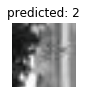

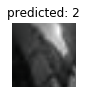

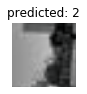

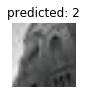

In [0]:
visualize_model(model_conv)

plt.ioff()
plt.show()

**BUSQUEDA DE DESCRIPTORES**

In [0]:
listaTEST = [f for f in listdir("TRAINYTEST2/TRAINYTEST2/TEST/1/desc") if isfile(join("TRAINYTEST2/TRAINYTEST2/TEST/1/desc", f))]            # Fem una llista d'arxius i després llegim les imatges a una matriu 3D.
test = np.array([np.array(Image.open("TRAINYTEST2/TRAINYTEST2/TEST/1/desc/" + fname)) for fname in listaTEST])                        

listaTRAIN = [f for f in listdir("TRAINYTEST2/TRAINYTEST2/TRAIN/2/catedrl") if isfile(join("TRAINYTEST2/TRAINYTEST2/TRAIN/2/catedrl", f))]         # Repetim el procés per TRAIN.
train = np.array([np.array(Image.open("TRAINYTEST2/TRAINYTEST2/TRAIN/2/catedrl/" + fname)) for fname in listaTRAIN])

In [0]:

print(train.shape)
print(test.shape)

Ntrain=len(train[:,1,1])
Ntest=len(test[:,1,1])  

mtrain = np.reshape(train, (58,784))
mtest = np.reshape(test, (1,784))

mtrain = skl.normalize(mtrain)     
mtest = skl.normalize(mtest)

mtrain = mtrain.transpose()

sims = np.matmul(mtest, mtrain)

ranks = np.argsort(sims, axis=1)[:,::-1]

(58, 28, 28)
(1, 28, 28)


In [0]:
#itzen perquè les imatges no son en escala de grisos realment i tenen 3 components,
# per tant per que funcioni hem hagut de substituir-ho pel nombre de fotos*3.
Ntrain=len(train[:,1,1])
Ntest=len(test[:,1,1])    

# Creem una versió de les matrius que tingui dues dimensions en una línia (28x28=784) y seguidament les normalitzem
mtrain = np.reshape(train, (58,784))
mtest = np.reshape(test, (1,784))

mtrain = skl.normalize(mtrain)     
mtest = skl.normalize(mtest)

# Calculem la trasposada per les similituds
mtrain = mtrain.transpose()

sims = np.matmul(mtest, mtrain)

ranks = np.argsort(sims, axis=1)[:,::-1]


# Visualització de les imatges
x_train_images = np.reshape(train, (58, 28, 28))
x_test_images = np.reshape(test, (1,28,28))

h,w = (28, 28)
new_image= Image.new('RGB', (h*10,w*4))

# Visualize ranks of the 10 queries
offset = 0 # it will show results from query #'offset' to #offset+10    900
for q in range(4):                                                      # 10
  ranks_q = ranks[q*(offset+1),:]
  for i in range(10):                                                   #15
      new_image.paste( Image.fromarray(x_train_images[ranks_q[i]]), (h*(1+i),w*q ))

  # visualize query
  ima_q = Image.fromarray(x_test_images[q*(offset+1),...])
  ima_q = ImageOps.expand(ima_q, border=3, fill='green')

  new_image.paste(ima_q, (0,w*q))

plt.figure()
plt.imshow(new_image)
plt.axis('off')
plt.show()

ValueError: ignored

**ADAPATACION DE LOS DESCRIPTORES**